In [23]:
#@title ###Connexion au Drive
#@markdown ---

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [24]:
#@title Chargement des librairies {display-mode: "form"}
#@markdown ---


import pandas as pd
import json
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math

!pip install azure-cognitiveservices-language-luis

from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient
from msrest.authentication import CognitiveServicesCredentials
from IPython.display import clear_output
clear_output()

In [25]:
#@title LOAD DATA {display-mode: "form"}
#@markdown ---

file_path = "/content/gdrive/MyDrive/00 - Ressources/0._Projets OC/P10_IA/Assets/frames.json" #@param {type:"string"}
df = pd.read_json(file_path)
print(df.shape)
df.head()

(1369, 5)


,user_id,turns,wizard_id,id,labels
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,"{'userSurveyRating': 3.0, 'wizardSurveyTaskSuc..."
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,"{'userSurveyRating': 2.0, 'wizardSurveyTaskSuc..."
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."


In [26]:
df["user_id"].nunique()

11

In [27]:
df_labels = pd.json_normalize(df['labels'])
df_labels.head()

,userSurveyRating,wizardSurveyTaskSuccessful
0,4.0,True
1,3.0,True
2,2.0,False
3,5.0,True
4,5.0,True


In [28]:
#@title LOAD SENTENCES FOR TRAINING LUIS {display-mode: "form"}
#@markdown ---


def _key_value_correspondence(association_value):

    list_key = ['or_city', 'dst_city', 'str_date', 'end_date', 'budget']
    if 'key' in association_value and 'val' in association_value:      
        if association_value['key'] in list_key and association_value['val'] != "-1" \
            and association_value['val'] != None:
            df_temp = pd.DataFrame(columns=['key','value'])
            list_dict = {association_value['key']: association_value['val']}
            # print (list_dict)
            return list_dict
    return None


def load(file_path):

    #load Data
    df_frame = pd.read_json(file_path)
    turns_series = df_frame['turns']
    data_list = turns_series.to_list()

    # pour toutes les conversations
    list_sentences = []
    for conversation in data_list:
        # et pour tous les dialogues
        for dialog in conversation:
            author = dialog['author']
            text = dialog['text']
            parametres_list = dialog['labels']['acts']
            dict_sentence = {'text':text, 'author':author}
            for parametre in parametres_list:
                if parametre['args']:
                    for arg in parametre['args']:
                        if not arg['key'] == 'ref':
                            dict_key = _key_value_correspondence(arg)
                            if dict_key:
                                dict_sentence.update(dict_key)
                        else:
                            annotations_list = arg['val'][0]['annotations']
                            if annotations_list:
                                for annotation_value in annotations_list:
                                    dict_key = _key_value_correspondence(
                                        annotation_value)
                                    if dict_key:
                                        dict_sentence.update(dict_key)                                          
            if dict_sentence:                           
                list_sentences.append(dict_sentence)
    return list_sentences


In [29]:
list_sentences = load(file_path)

In [30]:
df_train = pd.DataFrame(list_sentences)
print (df_train.shape)
df_train.head()

(19986, 7)


,text,author,dst_city,or_city,str_date,budget,end_date
0,I'd like to book a trip to Atlantis from Capri...,user,Atlantis,Caprica,"Saturday, August 13, 2016",1700,NaN
1,"Hi...I checked a few options for you, and unfo...",wizard,NaN,NaN,NaN,NaN,NaN
2,"Yes, how about going to Neverland from Caprica...",user,Neverland,Caprica,"August 13, 2016",1900,NaN
3,I checked the availability for this date and t...,wizard,NaN,NaN,NaN,NaN,NaN
4,I have no flexibility for dates... but I can l...,user,NaN,Caprica,NaN,NaN,NaN


In [31]:
df_train=df_train[df_train['author'] == 'user']
df_train.shape

(10407, 7)

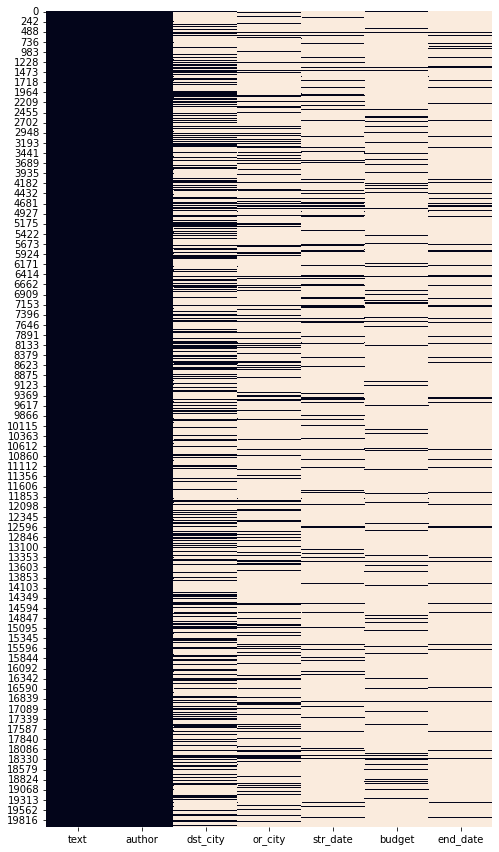

In [32]:
# Heatmap, visualisation des valeurs manquantes dans le tableau
plt.figure(figsize=(8,15))
sns.heatmap(df_train.isna(), cbar=False)

# LUIS CONFIGURATION

---



In [33]:
""" Luis Configuration """
class DefaultConfig:

    AUTHORING_KEY = "8c01558f6bd94a428dc8c7276a98c74a" #@param {type:"string"}
    AUTHORING_ENDPOINT ="https://bookingassistantbot-authoring.cognitiveservices.azure.com" #@param {type:"string"}
 
    PREDICTION_KEY = "949f5e56e84c4369aa2564a6a6879b4a" #@param {type:"string"}
    PREDICTION_ENDPOINT = "https://bookingassistantbot.cognitiveservices.azure.com" #@param {type:"string"}

In [34]:
CONFIG = DefaultConfig()

# Instantiate a LUIS client
client = LUISAuthoringClient(
    CONFIG.AUTHORING_ENDPOINT, CognitiveServicesCredentials(CONFIG.AUTHORING_KEY))

# CREATE APPLICATION

---



In [35]:
def create_app():
    app_name = "Fly Bot {}".format(datetime.datetime.now())
    app_desc = "Flight booking"
    app_version = "1.0"
    app_locale = "en-us"

    app_id = client.apps.add(dict(name=app_name,
                                  initial_version_id=app_version,
                                  description=app_desc,
                                  culture=app_locale))

    print("Created LUIS app {}\n    with ID {}".format(app_name, app_id))
    return app_id, app_version

In [36]:
print("Creating application...")
app_id, app_version = create_app()
print(app_id, app_version)

Creating application...
Created LUIS app Fly Bot 2022-04-12 07:43:38.319410
    with ID 13bb97b8-0f1d-4df2-a0de-5341f08499b6
13bb97b8-0f1d-4df2-a0de-5341f08499b6 1.0


# ADD ENTITIES

---



In [37]:
def add_entities(app_id, app_version):
    '''
        Creation of entities :
            - dst_city
            - or_city
            - budget
            - str_date
            - end_date
            Parameters:
                    app_id : luis application id
                    app_version : initial version of application
            Returns:
                    None
    '''
    dst_city_entity_id = client.model.add_entity(
        app_id, app_version, name="dst_city")
    print("destinationEntityId {} added.".format(dst_city_entity_id))

    or_city_entity_id = client.model.add_entity(
        app_id, app_version, name="or_city")
    print("classEntityId {} added.".format(or_city_entity_id))

    budget_entity_id = client.model.add_entity(
        app_id, app_version, name="budget")
    print("flightEntityId {} added.".format(budget_entity_id))

    start_date_entity_id = client.model.add_entity(
        app_id, app_version, name="str_date")
    print("flightEntityId {} added.".format(start_date_entity_id))

    end_date_entity_id = client.model.add_entity(
        app_id, app_version, name="end_date")
    print("flightEntityId {} added.".format(end_date_entity_id))

    datetime_entity_id = client.model.add_prebuilt(app_id, app_version, prebuilt_extractor_names=["datetimeV2"])
    print("flightEntityId {} added.".format(datetime_entity_id))

In [38]:
add_entities(app_id, app_version)

destinationEntityId 87776b77-1c9f-42f3-b4a1-97c8f01775b0 added.
classEntityId 0c6752fc-c1b0-495d-bfe0-cfe06a0d4525 added.
flightEntityId 87c3424b-d617-4def-8555-4eb424740b68 added.
flightEntityId 4f316ac5-3783-4b40-b736-b106f0f6294c added.
flightEntityId 11f6223c-f879-430f-9354-45f2ae0368d1 added.
flightEntityId [<azure.cognitiveservices.language.luis.authoring.models._models_py3.PrebuiltEntityExtractor object at 0x7fd781779390>] added.


# ADD INTENTS

---



In [39]:
def add_intents(app_id, app_version):
    '''
        Creation of intention :
            - BookFlight
            - Cancel
            - Greeting
            - Help
            - Closing
            Parameters:
                    app_id : luis application id
                    app_version : initial version of application
            Returns:
                    None
    '''
    intent_id = client.model.add_intent(app_id, app_version, "BookFlight")
    print("Intent BookFlight {} added.".format(intent_id))


In [40]:
add_intents(app_id, app_version)

Intent BookFlight ab442cf6-44e3-4fcc-962d-65c8d04653ab added.


# ADD UTTERANCES

---



In [41]:
def create_utterance(intent, utterance, *labels):
    """Add an example LUIS utterance from utterance text and a list of
       labels.  Each label is a 2-tuple containing a label name and the
       text within the utterance that represents that label.
       Utterances apply to a specific intent, which must be specified."""

    text = utterance.lower()

    def label(name, value):
        value = value.lower()
        start = text.index(value)
        return dict(entityName=name, startCharIndex=start,
                    endCharIndex=start + len(value))
    if len(labels)>0:
        return dict(text=text, intentName=intent,
                entityLabels=[label(n, v) for (n, v) in labels])

In [42]:
user_sentences_list = df_train.to_dict('records')
utterances=[]
for dict_temp in user_sentences_list:
    a_list = [(k, v) for k, v in dict_temp.items()]
    text = a_list[0][1]
    a_list.pop(0)
    a_list.pop(0)
    a_list =a_list
    utterance_tuple = tuple(a_list)
    utterance_tuple = [t for t in utterance_tuple if not any(isinstance(n, float) and math.isnan(n) for n in t)]
    utterances.append(create_utterance("BookFlight", text, *utterance_tuple))

res = []
for val in utterances:
    if val != None :
        res.append(val)

print(res[0])
print("{} example utterance(s) added.".format(len(res)))
train = res[:-99]
test = res[-99:]

print("{} train utterance(s) added.".format(len(train)))
print("{} test utterance(s) added.".format(len(test)))

{'text': "i'd like to book a trip to atlantis from caprica on saturday, august 13, 2016 for 8 adults. i have a tight budget of 1700.", 'intentName': 'BookFlight', 'entityLabels': [{'entityName': 'dst_city', 'startCharIndex': 27, 'endCharIndex': 35}, {'entityName': 'or_city', 'startCharIndex': 41, 'endCharIndex': 48}, {'entityName': 'str_date', 'startCharIndex': 52, 'endCharIndex': 77}, {'entityName': 'budget', 'startCharIndex': 117, 'endCharIndex': 121}]}
5229 example utterance(s) added.
5130 train utterance(s) added.
99 test utterance(s) added.


In [43]:
from google.colab import files
df_test = pd.DataFrame(test)
df_test.to_csv('test.csv') 
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
print("Adding intents to utterances...") 

for i in range(0, len(train), 100):
    j = (i + 100)
    if j > len(train):
        j = len(train)
    client.examples.batch(app_id, app_version, train[i:j], {'enableNestedChildren':True})
print("{} example utterance(s) added.".format(len(train)))

Adding intents to utterances...
5130 example utterance(s) added.


# TRAIN APPLICATION

---



In [45]:
def train_app(app_id, app_version):
    '''
        Train the luis application
            Parameters:
                    app_id : luis application id
                    app_version : initial version of application
            Returns:
                    None
    '''
    client.train.train_version(app_id, app_version)
    waiting = True
    while waiting:
        info = client.train.get_status(app_id, app_version)

        # get_status returns a list of training statuses,
        # one for each model. Loop through them and make sure all are done.
        waiting = any(map(lambda x: x.details.status ==
                      'Queued' or x.details.status == 'InProgress', info))
        if waiting:
            print("Waiting 10 seconds for training to complete...")
            time.sleep(10)

        else:
            print("trained")
            waiting = False

In [46]:
train_app(app_id, app_version)

Waiting 10 seconds for training to complete...
Waiting 10 seconds for training to complete...
Waiting 10 seconds for training to complete...
trained


# PUBLISH APP

---



In [47]:
def publish_app(app_id, app_version):
    print(app_id, app_version)

    client.apps.update_settings(app_id, is_public=True)
    response_endpoint_info = client.apps.publish(
        app_id, app_version, is_staging=False)
    #print(response_endpoint_info)
    print 
    print("Application published. Endpoint URL: " +
          response_endpoint_info.endpoint_url)

In [48]:
print("Publish application...")
publish_app(app_id, app_version)

Publish application...
13bb97b8-0f1d-4df2-a0de-5341f08499b6 1.0
Application published. Endpoint URL: https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/13bb97b8-0f1d-4df2-a0de-5341f08499b6


# PREDICTION 

---



In [49]:
# Use public app ID or replace with your own trained and published app's ID
# to query your own app

luisAppID = app_id
print("luisAppID: {}".format(luisAppID))

# `production` or `staging`
luisSlotName = 'production'
print("luisSlotName: {}".format(luisSlotName))
# </OtherVariables>

runtime_key = CONFIG.PREDICTION_KEY
print("runtime_key: {}".format(runtime_key))

runtime_endpoint = CONFIG.PREDICTION_ENDPOINT
print("runtime_endpoint: {}".format(runtime_endpoint))

clientRuntime = LUISRuntimeClient(runtime_endpoint, CognitiveServicesCredentials(runtime_key))

luisAppID: 13bb97b8-0f1d-4df2-a0de-5341f08499b6
luisSlotName: production
runtime_key: 949f5e56e84c4369aa2564a6a6879b4a
runtime_endpoint: https://bookingassistantbot.cognitiveservices.azure.com


In [50]:
def predict(app_id, slot_name):

    request = { "query" : "Find flight from Brest to Quimper tomorrow for 50 euros" }
    
	# Note be sure to specify, using the slot_name parameter, whether your application is in staging or production.
    response = clientRuntime.prediction.get_slot_prediction(app_id=app_id, slot_name=slot_name, prediction_request=request)
    
    print(request)
    print("Top intent: {}".format(response.prediction.top_intent))
    print("Sentiment: {}".format (response.prediction.sentiment))
    print("Intents: ")

    for intent in response.prediction.intents:
        print("\t{}".format (json.dumps (intent)))
    print("Entities: {}".format (response.prediction.entities))


In [51]:
predict(luisAppID, luisSlotName)

{'query': 'Find flight from Brest to Quimper tomorrow for 50 euros'}
Top intent: BookFlight
Sentiment: None
Intents: 
	"BookFlight"
Entities: {'or_city': ['Brest'], 'dst_city': ['Quimper'], 'str_date': ['tomorrow'], 'datetimeV2': [{'type': 'date', 'values': [{'timex': '2022-04-13', 'resolution': [{'value': '2022-04-13'}]}]}], 'budget': ['50 euros']}
